In [14]:
import os
import re
from itertools import product
from collections import defaultdict
import matplotlib.pyplot as plt



In [15]:
WORKDIR = '.'
CONFIG_FILE = os.path.join(WORKDIR, 'exp1_config.yml')
TEMP_CONFIG_FILE = os.path.join(WORKDIR, 'exp1_config_temp.yml')
SIMULATOR = os.path.join(WORKDIR, '../build/simulator')
TRACE_DIR = os.path.join(WORKDIR, '../traces')
TRACES = os.listdir(TRACE_DIR)
FIGURE_DIR = os.path.join(WORKDIR, 'figures')

if not os.path.exists(FIGURE_DIR):
    os.mkdir(FIGURE_DIR)

In [16]:
ATTRIBUTE = ['size', 'cache_line_bytes', 'associativity', 'write_back', 'write_allocate']
CACHE_SIZES = [32 * 4**i for i in range(6)]
BLOCK_SIZES = [32 * 2**i for i in range(6)]
ASSOCIATIVITIES = [2 ** i for i in range(6)]
WRITE_BACK = [True, False]
WRITE_ALLOCATE = [True, False]
LINE_FMTS = ['r--', 'o--', 'y--', 'g--', 'b--', 'p--']

In [17]:
def get_result(trace, cache_config):
    with open(TEMP_CONFIG_FILE, 'w') as tconf:
        with open(CONFIG_FILE, 'r') as conf:
            tconf.writelines(conf.readlines())
        tconf.writelines('    {}: {}\n'.format(k, v) for k, v in cache_config)

    with os.popen('{} -c {} {}'.format(SIMULATOR, TEMP_CONFIG_FILE, trace)) as result:
        lines = result.readlines()
        try:
            amat = float(re.search(r'AMAT: (\d+\.\d+) cycles', lines[-2]).group(1))
            miss_rate = float(re.search(r'miss_rate=(\d+\.\d+)%', lines[-1]).group(1))
            return amat, miss_rate
        except:
            print(lines)

In [ ]:
def get_data(trace):
    code = '{}'
    for _ in range(len(ATTRIBUTE) - 1):
        code = 'defaultdict(lambda: {})'.format(code)
    result = eval(code)
    for cache_config in product(CACHE_SIZES, BLOCK_SIZES, ASSOCIATIVITIES, WRITE_BACK, WRITE_ALLOCATE):
        size, block_size, assoc, write_back, write_alloc = cache_config
        result[size][block_size][assoc][write_back][write_alloc] = get_result(trace, zip(ATTRIBUTE, cache_config))
    return result
    
data = {}
for trace in TRACES:
    data[trace] = get_data(os.path.join(TRACE_DIR, trace))

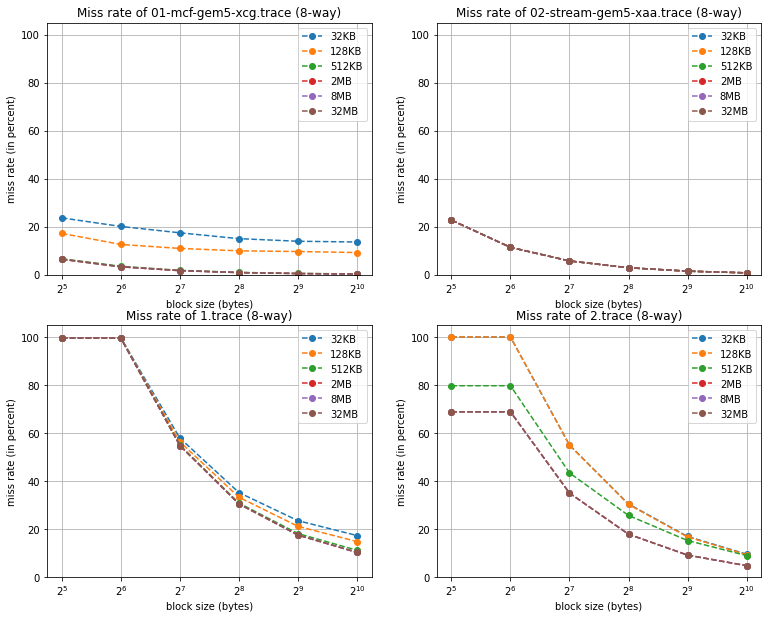

In [42]:

def draw_block_size(trace_name, assoc, data, savefig=None):
    plt.title('Miss rate of {} ({}-way)'.format(trace_name, assoc))
    plt.xlabel('block size (bytes)')
    plt.ylabel('miss rate (in percent)')
    # plt.axis([BLOCK_SIZES[0], BLOCK_SIZES[-1], 0, 100])
    plt.ylim(0, 105)
    plt.xscale('log', basex=2)
    plt.grid(True)
    
    line_label = []
    line = []
    for size, fmt in zip(CACHE_SIZES, LINE_FMTS):
        line_label.append(str(size) + 'KB' if size <= 1024 else str(size >> 10) + 'MB')
        y_data = [data[size][bs][assoc][True][True][1] for bs in BLOCK_SIZES]
        line.append(plt.plot(BLOCK_SIZES, y_data, 'o--')[0])
    plt.legend(handles=line, labels=line_label)
    
    # if savefig:
    #     filename = 'miss-rate_{}_{}-way.png'.format(trace_name, assoc)
    #     plt.savefig(os.path.join(FIGURE_DIR, filename))

    # plt.show()

plt.figure(figsize=(6.4 * 2, 4.8 * 2 + 0.6))
for i, trace in enumerate(TRACES, 1):
    plt.subplot(220 + i)
    draw_block_size(trace, 8, data[trace])
plt.savefig(os.path.join(FIGURE_DIR, 'missrate_8-way.png'))
plt.show()

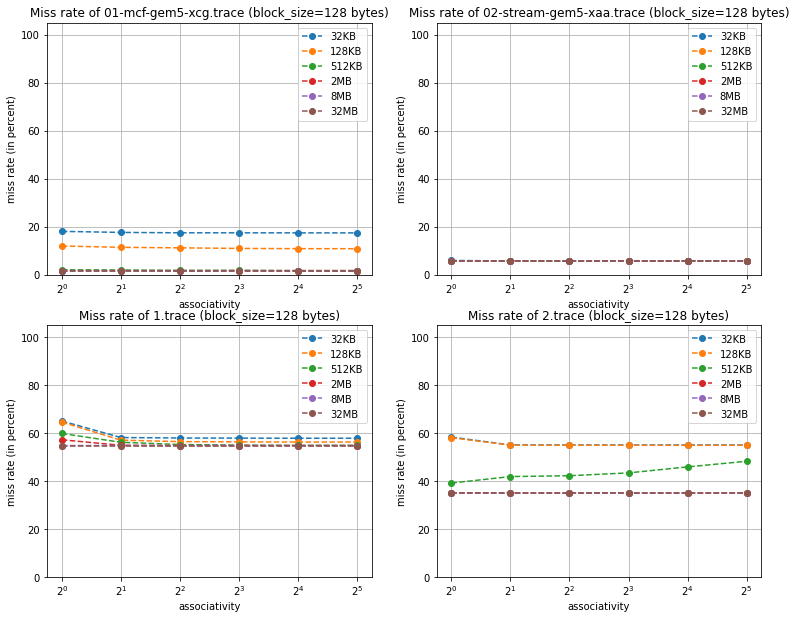

In [44]:

def draw_assoc(trace_name, block_size, data, fig_file = None):
    plt.title('Miss rate of {} (block_size={} bytes)'.format(trace_name, block_size))
    plt.xlabel('associativity')
    plt.ylabel('miss rate (in percent)')
    # plt.axis([BLOCK_SIZES[0], BLOCK_SIZES[-1], 0, 100])
    plt.ylim(0, 105)
    plt.xscale('log', basex=2)
    plt.grid(True)
    
    line_label = []
    line = []
    for size in CACHE_SIZES:
        line_label.append(str(size) + 'KB' if size <= 1024 else str(size >> 10) + 'MB')
        y_data = [data[size][block_size][assoc][True][True][1] for assoc in ASSOCIATIVITIES]
        line.append(plt.plot(ASSOCIATIVITIES, y_data, 'o--')[0])
    plt.legend(handles=line, labels=line_label)
    
    # plt.show()

plt.figure(figsize=(6.4 * 2, 4.8 * 2 + 0.6))
for i, trace in enumerate(TRACES, 1):
    plt.subplot(220 + i)
    draw_assoc(trace, 128, data[trace])
plt.savefig(os.path.join(FIGURE_DIR, 'missrate_128-bytes.png'))
plt.show()

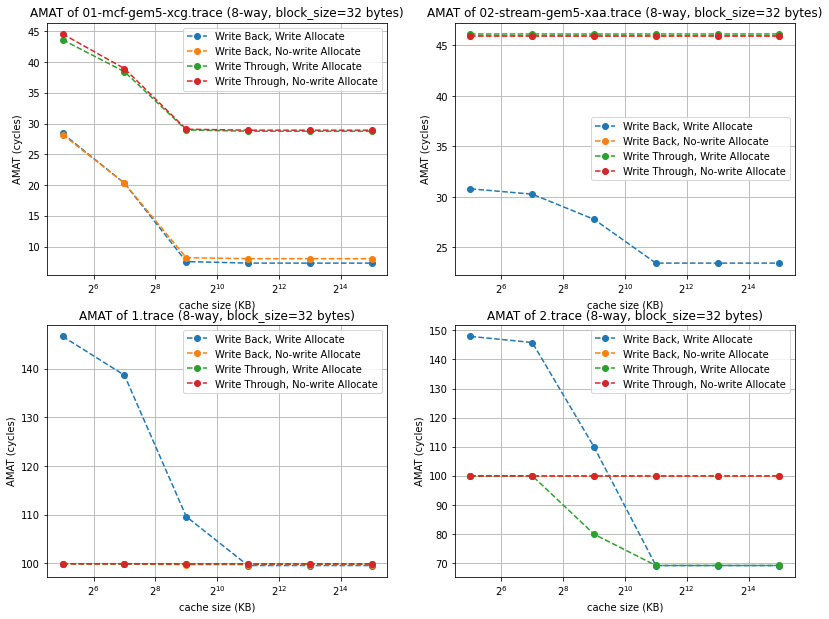

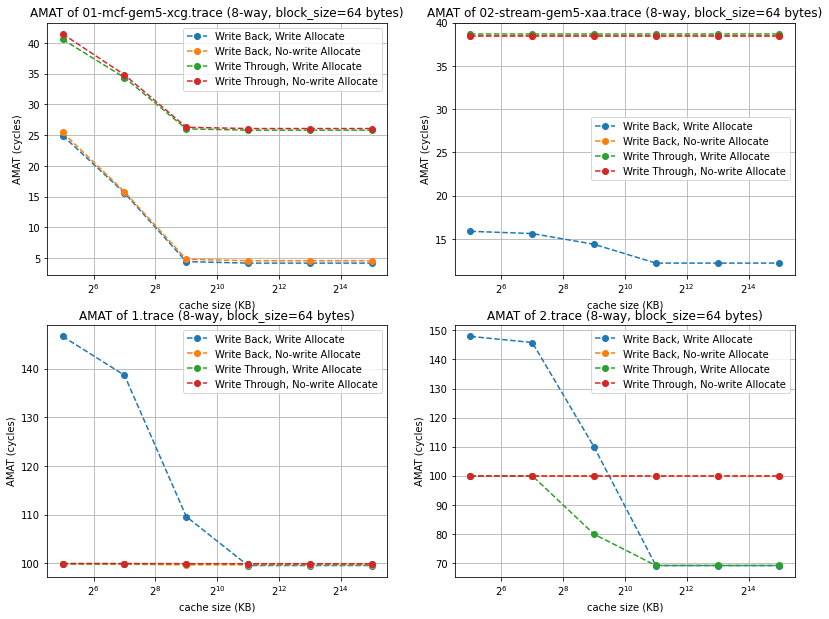

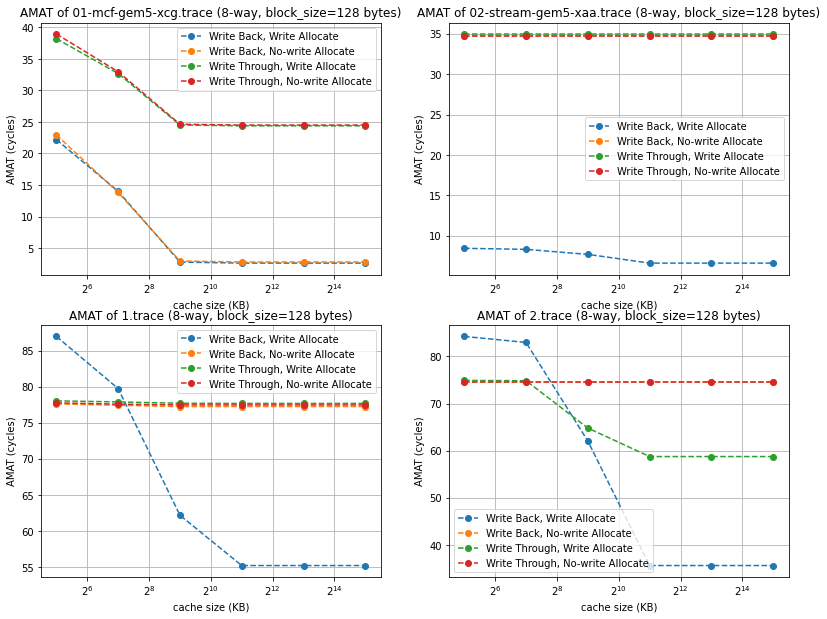

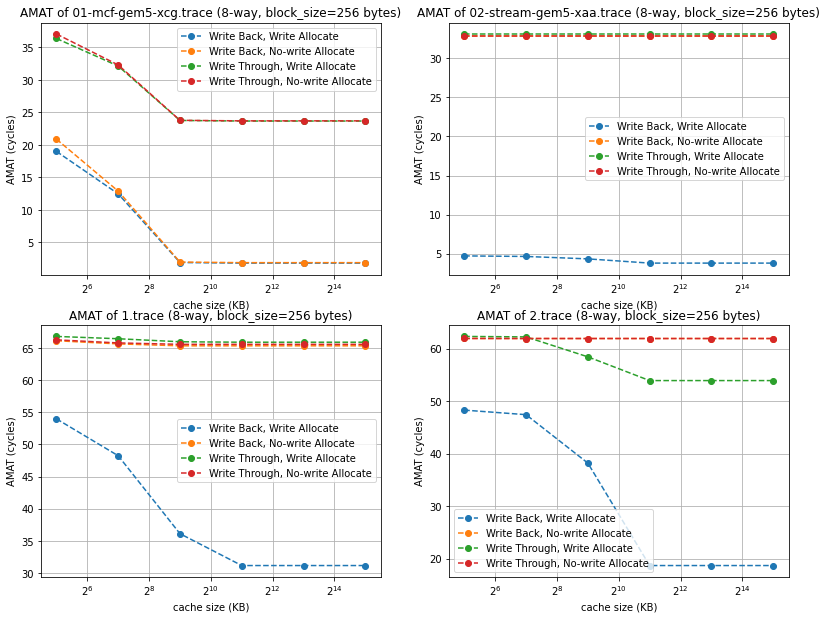

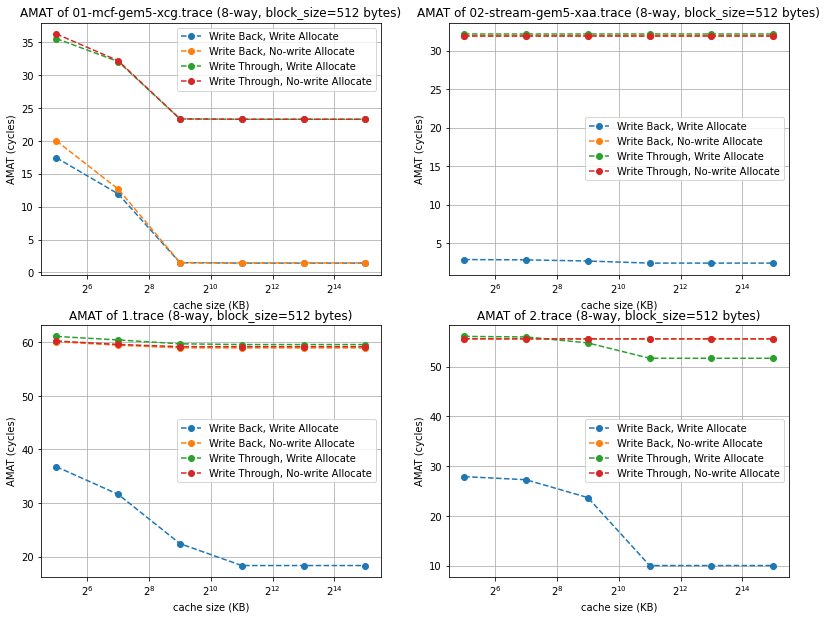

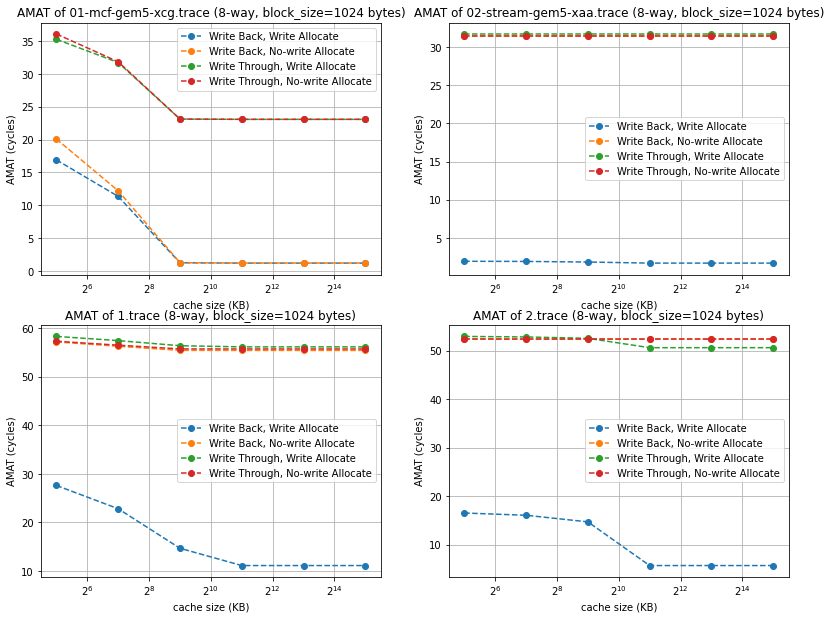

In [48]:
def draw_write_strategy(trace_name, block_size, assoc, data, fig_file=None):
    plt.title('AMAT of {} ({}-way, block_size={} bytes)'.format(trace_name, assoc, block_size))
    plt.xlabel('cache size (KB)')
    plt.xscale('log', basex=2)
    plt.ylabel('AMAT (cycles)')
    plt.grid(True)

    line_label = []
    line = []
    for write_back, write_alloc in product(WRITE_BACK, WRITE_ALLOCATE):
        label = 'Write Back' if write_back else 'Write Through'
        label += ', '
        label += 'Write Allocate' if write_alloc else 'No-write Allocate'
        line_label.append(label)
        y_data = [data[size][block_size][assoc][write_back][write_alloc][0] for size in CACHE_SIZES]
        line.append(plt.plot(CACHE_SIZES, y_data, 'o--')[0])
    plt.legend(handles=line, labels=line_label)

    # plt.show()

for block_size in BLOCK_SIZES:
    plt.figure(figsize=(6.4 * 2 + 0.6, 4.8 * 2 + 0.6))
    for i, trace in enumerate(TRACES, 1):
        plt.subplot(220 + i)
        draw_write_strategy(trace, block_size, 8, data[trace])
    # plt.savefig(os.path.join(FIGURE_DIR, 'missrate_128-bytes_8-way.png'))
    plt.show()
    

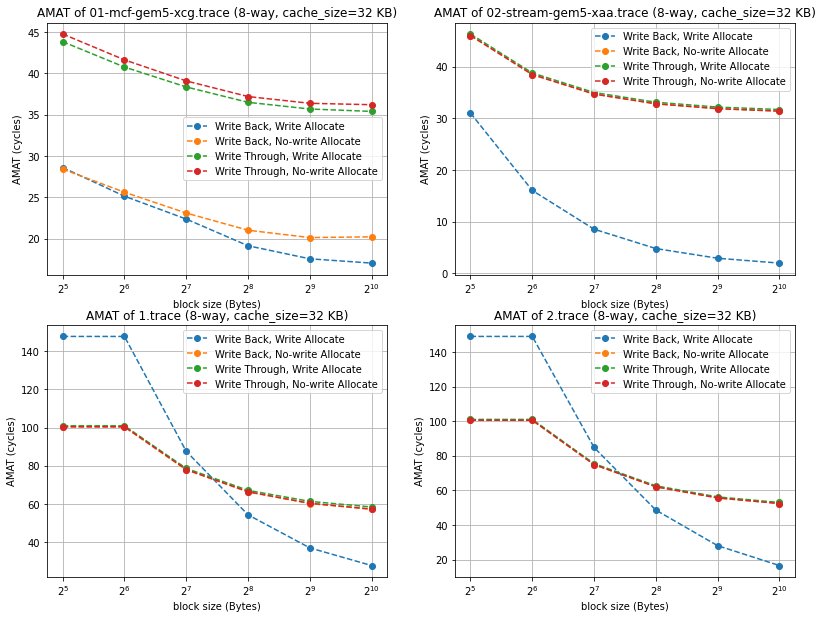

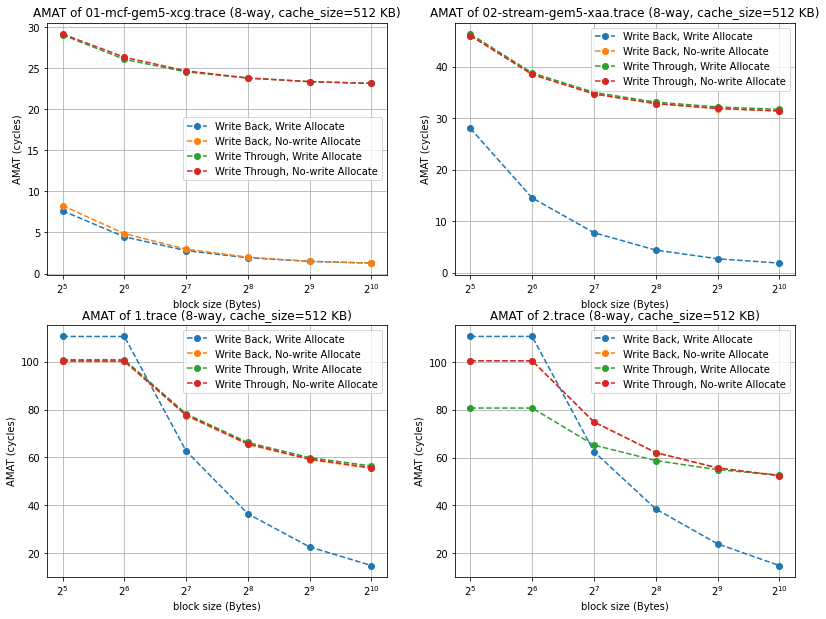

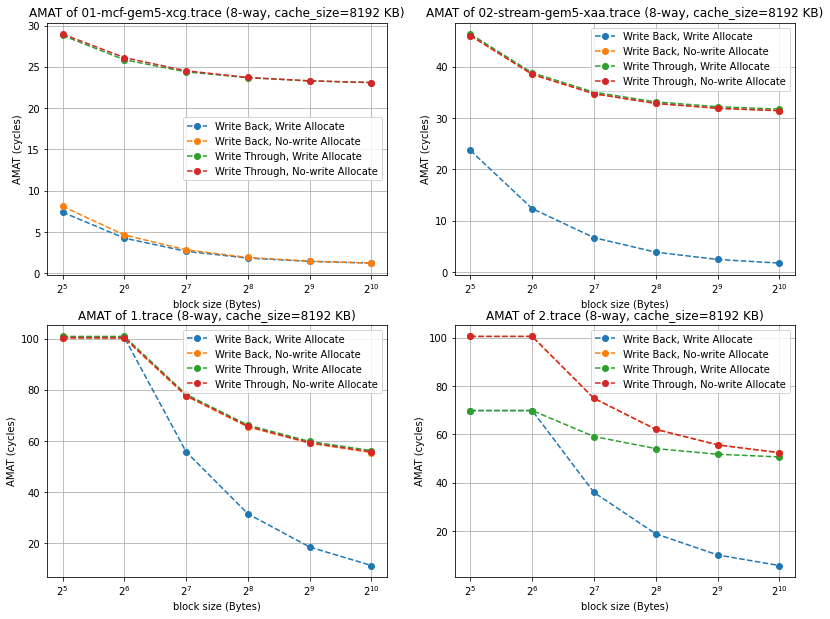

In [20]:
def draw_write_strategy(trace_name, size, assoc, data, fig_file=None):
    plt.title('AMAT of {} ({}-way, cache_size={} KB)'.format(trace_name, assoc, size))
    plt.xlabel('block size (Bytes)')
    plt.xscale('log', basex=2)
    plt.ylabel('AMAT (cycles)')
    plt.grid(True)

    line_label = []
    line = []
    for write_back, write_alloc in product(WRITE_BACK, WRITE_ALLOCATE):
        label = 'Write Back' if write_back else 'Write Through'
        label += ', '
        label += 'Write Allocate' if write_alloc else 'No-write Allocate'
        line_label.append(label)
        y_data = [data[size][block_size][assoc][write_back][write_alloc][0] for block_size in BLOCK_SIZES]
        line.append(plt.plot(BLOCK_SIZES, y_data, 'o--')[0])
    plt.legend(handles=line, labels=line_label)

    # plt.show()

for size in CACHE_SIZES[::2]:
    plt.figure(figsize=(6.4 * 2 + 0.6, 4.8 * 2 + 0.6))
    for i, trace in enumerate(TRACES, 1):
        plt.subplot(220 + i)
        draw_write_strategy(trace, size, 8, data[trace])
    plt.savefig(os.path.join(FIGURE_DIR, 'missrate_{}KB_8-way.png'.format(size)))
    plt.show()
    